In [1]:
!pip install opencv-python tensorflow scikit-learn matplotlib seaborn --quiet

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"pedictron","key":"585cc0c1cc2d26e2a7a09a29cc6dcefd"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Check it's working
!kaggle datasets list -s garbage


ref                                                        title                                                  size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  -----------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
asdasdasasdas/garbage-classification                       Garbage Classification                             85969666  2018-11-24 05:09:23.977000          54900        576  0.8125           
sumn2u/garbage-classification-v2                           Garbage Dataset                                   780289207  2024-12-12 15:55:45.503000          12106         76  1.0              
mostafaabla/garbage-classification                         Garbage Classification (12 classes)               250641573  2021-01-24 13:53:11.647000          27409        203  0.8125           
farzadnekouei/trash-type-image-dataset  

In [5]:
!kaggle datasets download -d asdasdasasdas/garbage-classification


Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
  0% 0.00/82.0M [00:00<?, ?B/s]
100% 82.0M/82.0M [00:00<00:00, 1.21GB/s]


In [6]:
!unzip garbage-classification.zip


Streaming output truncated to the last 5000 lines.
  inflating: Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/cardboard160.jpg  
  inflating: Garbage classification/Garbage classification/cardboard/c

In [7]:
import os

base_dir = "/content/Garbage classification"  # Change this if your folder name is different

for folder in os.listdir(base_dir):
    print(folder, "->", len(os.listdir(os.path.join(base_dir, folder))), "images")


Garbage classification -> 6 images


In [9]:
!ls -R /content



/content:
'garbage classification'	      one-indexed-files-notrash_train.txt
'Garbage classification'	      one-indexed-files-notrash_val.txt
 garbage-classification.zip	      one-indexed-files.txt
 kaggle.json			      sample_data
 one-indexed-files-notrash_test.txt   zero-indexed-files.txt

'/content/garbage classification':
'Garbage classification'

'/content/garbage classification/Garbage classification':
cardboard  glass  metal  paper	plastic  trash

'/content/garbage classification/Garbage classification/cardboard':
cardboard100.jpg  cardboard192.jpg  cardboard283.jpg  cardboard374.jpg
cardboard101.jpg  cardboard193.jpg  cardboard284.jpg  cardboard375.jpg
cardboard102.jpg  cardboard194.jpg  cardboard285.jpg  cardboard376.jpg
cardboard103.jpg  cardboard195.jpg  cardboard286.jpg  cardboard377.jpg
cardboard104.jpg  cardboard196.jpg  cardboard287.jpg  cardboard378.jpg
cardboard105.jpg  cardboard197.jpg  cardboard288.jpg  cardboard379.jpg
cardboard106.jpg  cardboard198.jpg  cardboard28

In [11]:
import matplotlib.pyplot as plt
import cv2
import random

categories = os.listdir(base_dir)
plt.figure(figsize=(12, 8))

for i, category in enumerate(categories):
    folder = os.path.join(base_dir, category)
    img_files = os.listdir(folder)

    if len(img_files) == 0:
        continue  # Skip empty folders

    found_valid_image = False
    while not found_valid_image and len(img_files) > 0:
        img_name = random.choice(img_files)
        img_path = os.path.join(folder, img_name)

        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.subplot(2, len(categories) // 2 + 1, i+1)
            plt.imshow(img)
            plt.title(category)
            plt.axis('off')
            found_valid_image = True
        else:
            img_files.remove(img_name)  # Try another file

plt.tight_layout()
plt.show()


<Figure size 1200x800 with 0 Axes>

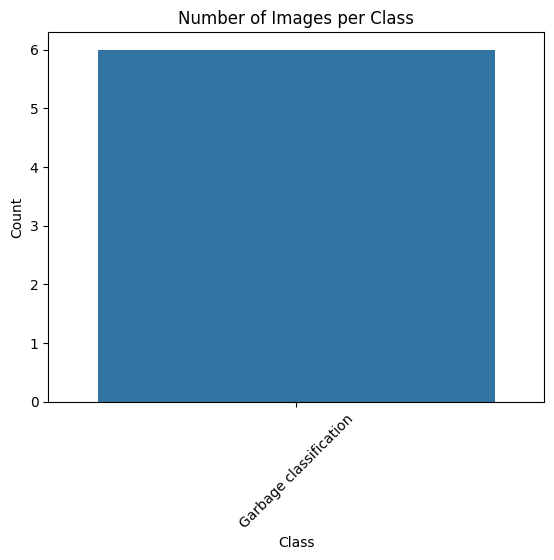

In [12]:
import seaborn as sns
import pandas as pd

class_counts = {cat: len(os.listdir(os.path.join(base_dir, cat))) for cat in categories}
df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Count"])

sns.barplot(data=df, x="Class", y="Count")
plt.title("Number of Images per Class")
plt.xticks(rotation=45)
plt.show()


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Base directory where class folders are stored
base_dir = "/content/Garbage classification"  # Adjust if needed

# Image dimensions
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32


In [14]:
# Define image generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,     # 20% for validation
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    rotation_range=15
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load images from folders
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Optional: You can split out a test set separately later, or use validation as test


Found 2022 images belonging to 1 classes.
Found 505 images belonging to 1 classes.


In [15]:
print("Classes:", train_generator.class_indices)

# View one batch of images
images, labels = next(train_generator)
print("Image batch shape:", images.shape)
print("Label batch shape:", labels.shape)


Classes: {'Garbage classification': 0}
Image batch shape: (32, 128, 128, 3)
Label batch shape: (32, 1)


In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    # 1st Convolutional Layer
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2,2),

    # 2nd Convolutional Layer
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # 3rd Convolutional Layer
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Flatten and Dense layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # helps avoid overfitting
    Dense(train_generator.num_classes, activation='softmax')  # Output layer
])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)


In [19]:
history = model.fit(
    train_generator,
    epochs=20,  # You can increase to 15–20 later
    validation_data=validation_generator,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py:33: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return self.fn(y_true, y_pred, **self._fn_kwargs)


64/64 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00


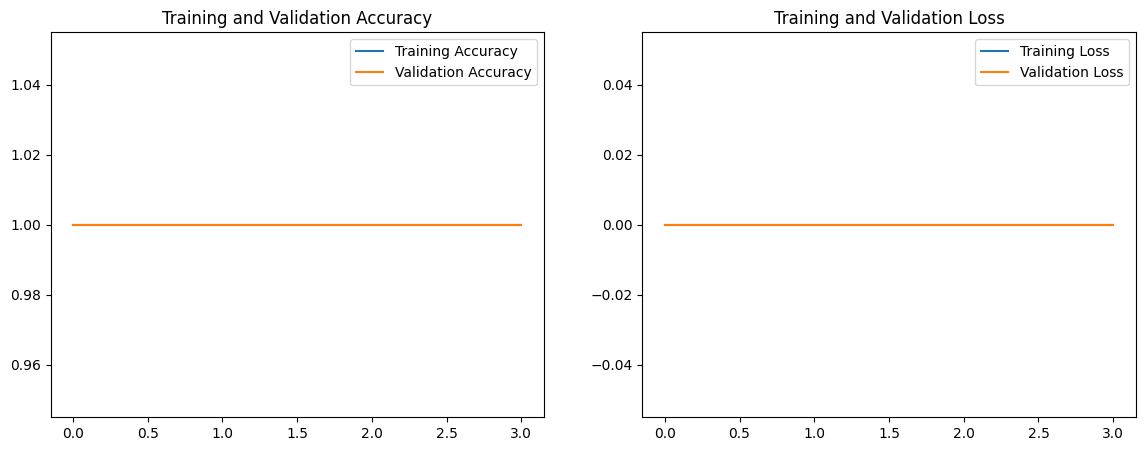

In [20]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()


In [ ]:
val_loss, val_acc = model.evaluate(validation_generator)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


13/16 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step - accuracy: 1.0000 - loss: 0.0000e+00

/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py:907: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 633ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


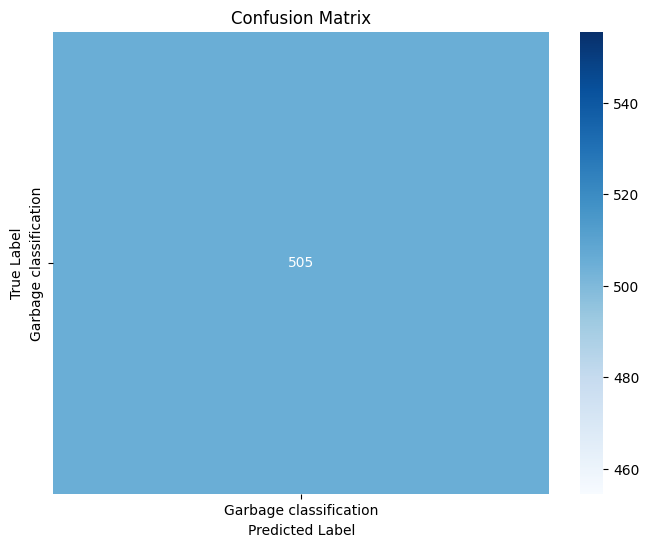

                        precision    recall  f1-score   support

Garbage classification       1.00      1.00      1.00       505

              accuracy                           1.00       505
             macro avg       1.00      1.00      1.00       505
          weighted avg       1.00      1.00      1.00       505



In [22]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels and predictions
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=labels))


16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 499ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


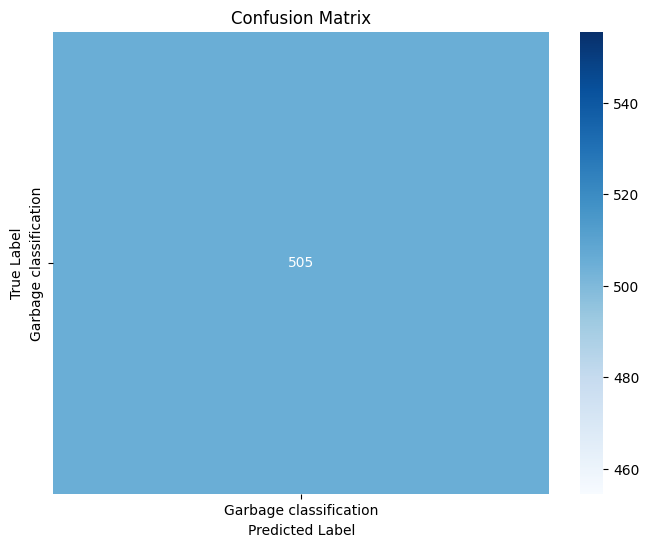

                        precision    recall  f1-score   support

Garbage classification       1.00      1.00      1.00       505

              accuracy                           1.00       505
             macro avg       1.00      1.00      1.00       505
          weighted avg       1.00      1.00      1.00       505



In [23]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels and predictions
Y_pred = model.predict(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes
labels = list(validation_generator.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=labels))


Saving vegetables.webp to vegetables.webp
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Predicted class: Garbage classification


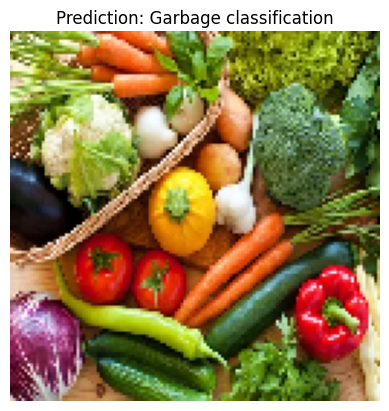

In [26]:
from tensorflow.keras.preprocessing import image
from google.colab import files

uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Load and preprocess the image
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make prediction
pred = model.predict(img_array)
predicted_class = labels[np.argmax(pred)]
print("Predicted class:", predicted_class)

# Show image
plt.imshow(img)
plt.title(f"Prediction: {predicted_class}")
plt.axis('off')
plt.show()


In [27]:
model.save("recyclable_classifier.h5")


In [28]:
from google.colab import files
files.download("recyclable_classifier.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>